In [24]:
# Packages
import torch
import lightning as L
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.functional import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings

# my model
from model.basicNN import L_NN_Pred as pred

In [25]:
# model setting
model = pred(in_feature=13, h1=26, h2=27, h3=28, out_feature=1)
torch.manual_seed = 81
epochs = 100
batch_size = 32
log_every_n_step = 10

In [26]:
# import data
warnings.filterwarnings('ignore')
directory = "data\Boston\BostonHousing.csv"  # can use url
df = pd.read_csv(directory, delimiter=",")
df = df.astype('float')
print(df.head())

# normalization with MinMaxscaler
scaler = MinMaxScaler()
df.iloc[:, np.r_[1:3, 5:14]] = scaler.fit_transform(df.iloc[:, np.r_[1:3, 5:14]])
# normalize all column except number 4 "CHAS"

X = df.drop(["medv"], axis=1)  # axis=1 =remove column, axis=0 = remove 1st row/index
y = df["medv"]
# assigning inputs and labels and convert to tensor
input = torch.FloatTensor(X.values)
label = torch.FloatTensor(y.values)
label = label.reshape(-1, 1)
  # transform label to dim (n, 1) for loss calculation
# train test split
train_input, test_input, train_label, test_label = train_test_split(
    input,
    label,
    test_size=0.2,
    random_state=81,
)
train_dataset = TensorDataset(train_input, train_label)
test_dataset = TensorDataset(test_input, test_label)
# dataloader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)


      crim    zn  indus  chas    nox     rm   age     dis  rad    tax  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   ptratio       b  lstat  medv  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [27]:
# training 
trainer = L.Trainer(max_epochs=epochs, log_every_n_steps=log_every_n_step)

# learning rate finder
tuner = L.pytorch.tuner.Tuner(trainer)
lr_find_results = tuner.lr_find(
    model,
    train_dataloaders=train_loader,
    min_lr=0.001,
    max_lr=1.0,
    early_stop_threshold=None,
)
new_lr = lr_find_results.suggestion()
model.learning_rate = new_lr
print(f"lr_find() suggest {new_lr:5f} for the learning rate.")
# train to fit
trainer.fit(model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 200.27it/s]
Learning rate set to 0.0039810717055349725
Restoring states from the checkpoint path at d:\Work repository\NN_test_build\.lr_find_5a2a71ec-e00e-4195-b6df-16862ca13e53.ckpt
Restored all states from the checkpoint at d:\Work repository\NN_test_build\.lr_find_5a2a71ec-e00e-4195-b6df-16862ca13e53.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 364    | train
1 | fc2  | Linear | 729    | train
2 | fc3  | Linear | 784    | train
3 | out  | Linear | 29     | train
----------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
4         Modules in train mode
0    

lr_find() suggest 0.003981 for the learning rate.
Epoch 99: 100%|██████████| 13/13 [00:00<00:00, 142.31it/s, v_num=7]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 13/13 [00:00<00:00, 132.48it/s, v_num=7]


In [28]:
# continue training
path_to_best_checkpoint = trainer.checkpoint_callback.best_model_path
trainer = L.Trainer(max_epochs=300, log_every_n_steps=log_every_n_step)
trainer.fit(model, train_dataloaders=train_loader, ckpt_path=path_to_best_checkpoint)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at d:\Work repository\NN_test_build\lightning_logs\version_7\checkpoints\epoch=99-step=1300.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 364    | train
1 | fc2  | Linear | 729    | train
2 | fc3  | Linear | 784    | train
3 | out  | Linear | 29     | train
----------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at d:\Work repository\NN_test_build\lightning_logs\version_7\checkpoints\epoch=99-step=1300.ckpt


Epoch 299: 100%|██████████| 13/13 [00:00<00:00, 137.75it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 13/13 [00:00<00:00, 128.91it/s, v_num=8]


In [ ]:
# monitor loss by tensorboard
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at d:\Work repository\NN_test_build\lightning_logs\version_8\checkpoints\epoch=299-step=3900.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at d:\Work repository\NN_test_build\lightning_logs\version_8\checkpoints\epoch=299-step=3900.ckpt


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 337.88it/s]


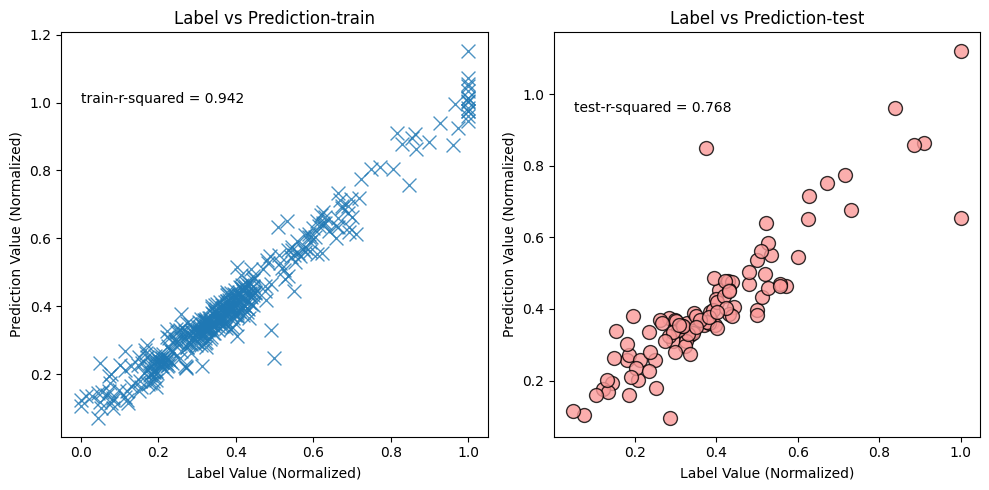

In [29]:
# Test and visualizing result
warnings.filterwarnings('ignore')
with torch.no_grad():
    best_ckpt = trainer.checkpoint_callback.best_model_path
    tester = L.Trainer()
    tester.test(model, dataloaders=test_loader, ckpt_path=best_ckpt)



# Visalizing result
train_res = model.forward(train_input).detach()
test_res = model.forward(test_input).detach()

plt.figure(figsize=(10, 5))
plt.style.use("seaborn-v0_8-colorblind")
plt.subplot(1, 2, 1)
plt.scatter(
    train_label,
    train_res,
    marker="x",  # marker shape
    s=100,  # marker size
    c="#1f78b4",  # marker color hex code (blue)
    edgecolors="black",  # axis color
    linewidths=1,  # axis width
    alpha=0.80,  # axis alpha
)
plt.title("Label vs Prediction-train")
plt.xlabel("Label Value (Normalized)")
plt.ylabel("Prediction Value (Normalized)")
plt.annotate("train-r-squared = {:.3f}".format(r2_score(train_label, train_res)), (0, 1))
# (0,1) argument sets location of the annotation

plt.subplot(1, 2, 2)
plt.scatter(
    test_label,
    test_res,
    marker="o",  # marker shape
    s=100,  # marker size
    c="#fb9a99",  # marker color hex code (grapefruit)
    edgecolors="black",  # axis color
    linewidths=1,  # axis width
    alpha=0.80,  # axis alpha
)
plt.title("Label vs Prediction-test")
plt.xlabel("Label Value (Normalized)")
plt.ylabel("Prediction Value (Normalized)")
plt.annotate("test-r-squared = {:.3f}".format(r2_score(test_label, test_res)), (0.05, 0.95))
# (0,1) argument sets location of the annotation

plt.tight_layout()
plt.show()

In [ ]:
# saving model and parameters
torch.save(model.state_dict(), "trained_parameters\l_pd_BostonHousing.pt")

In [10]:
# load saved model
warnings.filterwarnings('ignore')
loaded_model = pred(in_feature=13, h1=26, h2=27, h3=28, out_feature=1)
loaded_model.load_state_dict(torch.load("trained_parameters\l_pd_BostonHousing.pt"))

<All keys matched successfully>

In [11]:
# load CSV dataset for prediction
warnings.filterwarnings('ignore')
directory = "data\Boston\BostonHousing_100.csv"  # randomly selected 100 data to resemble real data
df_real = pd.read_csv(directory, delimiter=",")
df_real = df_real.astype("float")
# Normalize with training scaler
df_real.iloc[:, np.r_[1:3, 5:14]] = scaler.transform(df_real.iloc[:, np.r_[1:3, 5:14]])
#convert to tensor 
real_X = df_real.drop(["medv"], axis=1) 
real_input = torch.FloatTensor(real_X.values)  # convert to tensor
#prediction
pred_res = loaded_model.forward(real_input).clone().detach()

# reverse scaler
pred_medv = pd.DataFrame(pred_res.numpy())  # convert tensor to df
real_X.insert(loc=13, column="medv", value=pred_medv, allow_duplicates=False)
price_pred = real_X.astype("float")
price_pred.iloc[:, np.r_[1:3, 5:14]] = scaler.inverse_transform(
    price_pred.iloc[:, np.r_[1:3, 5:14]]
)
print(price_pred.head())

      crim    zn  indus  chas    nox     rm   age     dis  rad    tax  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   ptratio       b  lstat       medv  
0     15.3  396.90   4.98  22.321754  
1     17.8  396.90   9.14  21.422078  
2     17.8  392.83   4.03  34.064385  
3     18.7  394.63   2.94  34.167312  
4     18.7  396.90   5.33  35.315498  


In [ ]:
# save prediction as new csv if necessary
price_pred.to_csv("Price_prediction.csv", index=False)  